In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sqlite3
sns.set_style('darkgrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/hyperion/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()

In [3]:
# View all columns on the screen
pd.set_option('max_columns', 100)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth',1000)

## Load trip data from DB
---

### There are 15 million rows in the database - I use a week of data instead

In [4]:
query_string1 = '''
                select * from trips where pickup_datetime < '2013-04-08' order by pickup_datetime asc
'''

In [5]:
# Connect to the existing fleetriskdb
con = sqlite3.connect('./DB/nyctaxidb.sqlite')
# Confirm data is being returned from this query
trip_data_df = pd.read_sql_query(query_string1, con)
# Verify that result of SQL query is stored in the dataframe
trip_data_df.tail()

,index,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
3519773,10926424,D5AF01D58DA48FFF46169C232017673F,BBB0371651B842361E8068F803BD5AFE,CMT,1,N,2013-04-07 23:59:56,2013-04-08 00:23:59,1,1443,6.3,-74.002426,40.730354,-73.953674,40.787910
3519774,10943237,7E64B77A336CD52A4A081F1B0066954C,6452FBD410A159B4A3E17C7EA4FE7293,CMT,1,N,2013-04-07 23:59:56,2013-04-08 00:05:38,1,342,1.4,-73.980347,40.775566,-73.962570,40.764313
3519775,10694065,6AC551DA4299581A398D8A9D0AC7C25F,541BC740DB8088C1AB92D770F664D8EC,CMT,1,N,2013-04-07 23:59:57,2013-04-08 00:02:25,1,147,1.0,-73.990868,40.749439,-74.001015,40.737099
3519776,12497919,23A3564F3D4A361A3D3F8D8FE8E7D2FF,90C3F339879C9E6C61805622382881D5,CMT,1,N,2013-04-07 23:59:58,2013-04-08 00:03:37,2,218,0.9,-73.989685,40.751415,-73.990524,40.760773
3519777,12490214,291758BBCA44E8AFF6554E526B423A39,5647761721D488C1F671072B01AA83F5,CMT,1,N,2013-04-07 23:59:59,2013-04-08 00:07:51,1,471,1.9,-73.988693,40.734016,-73.986870,40.755569


In [6]:
con.close()

In [7]:
trip_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3519778 entries, 0 to 3519777
Data columns (total 15 columns):
index                 int64
medallion             object
hack_license          object
vendor_id             object
rate_code             int64
store_and_fwd_flag    object
pickup_datetime       object
dropoff_datetime      object
passenger_count       int64
trip_time_in_secs     int64
trip_distance         float64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
dtypes: float64(5), int64(4), object(6)
memory usage: 402.8+ MB


In [8]:
trip_data_df.shape[0]

3519778

## Scrub trip data for outliers

In [9]:
# Create a new dataframe for the cleaned trips data
trips_df = trip_data_df.copy()
# Check for nulls
trips_df.isnull().sum()

index                       0
medallion                   0
hack_license                0
vendor_id                   0
rate_code                   0
store_and_fwd_flag    1750728
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
trip_time_in_secs           0
trip_distance               0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude          36
dropoff_latitude           36
dtype: int64

In [10]:
# Let's drop the store_and_fwd_flag column and the null values of latitude and longitude
trips_df = trips_df.drop('store_and_fwd_flag', axis=1)
trips_df.columns

Index([u'index', u'medallion', u'hack_license', u'vendor_id', u'rate_code', u'pickup_datetime', u'dropoff_datetime', u'passenger_count', u'trip_time_in_secs', u'trip_distance', u'pickup_longitude', u'pickup_latitude', u'dropoff_longitude', u'dropoff_latitude'], dtype='object')

In [11]:
trips_df = trips_df[~trips_df.dropoff_latitude.isnull()]
trips_df = trips_df[~trips_df.dropoff_longitude.isnull()]

In [12]:
trips_df.isnull().sum()

index                0
medallion            0
hack_license         0
vendor_id            0
rate_code            0
pickup_datetime      0
dropoff_datetime     0
passenger_count      0
trip_time_in_secs    0
trip_distance        0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
dtype: int64

In [13]:
trips_df.describe()

,index,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,3.519742e+06,3.519742e+06,3.519742e+06,3.519742e+06,3.519742e+06,3.519742e+06,3.519742e+06,3.519742e+06,3.519742e+06
mean,1.159821e+07,1.033172e+00,1.717254e+00,7.500107e+02,2.867673e+00,-7.272865e+01,4.006971e+01,-7.268611e+01,4.004336e+01
std,2.685823e+06,3.141468e-01,1.387909e+00,5.555801e+02,3.364425e+00,9.751638e+00,6.216547e+00,9.892353e+00,6.767633e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.323420e+03,-3.116352e+03,-2.443862e+03,-3.281102e+03
25%,1.095135e+07,1.000000e+00,1.000000e+00,3.600000e+02,1.030000e+00,-7.399216e+01,4.073477e+01,-7.399149e+01,4.073395e+01
50%,1.189631e+07,1.000000e+00,1.000000e+00,6.000000e+02,1.780000e+00,-7.398180e+01,4.075264e+01,-7.398014e+01,4.075317e+01
75%,1.362739e+07,1.000000e+00,2.000000e+00,9.600000e+02,3.200000e+00,-7.396671e+01,4.076747e+01,-7.396365e+01,4.076823e+01
max,1.471133e+07,2.100000e+02,8.000000e+00,1.074000e+04,1.000000e+02,1.566670e-01,3.210393e+03,1.428739e+03,3.210369e+03


In [14]:
# Sanity check Latitude values
trips_df[trips_df.pickup_latitude==0.0].shape[0]

58849

In [15]:
trips_df[trips_df.dropoff_latitude==0.0].shape[0]

60858

In [16]:
# Sanity Check Longitude Values
trips_df[trips_df.pickup_longitude==0.0].shape[0]

59379

In [17]:
trips_df[trips_df.dropoff_longitude==0.0].shape[0]

61332

In [18]:
# How many trips are 0 secs?
trips_df[trips_df.trip_time_in_secs==0].shape[0]

8355

In [19]:
# How many trips are 0km?
trips_df[trips_df.trip_distance==0].shape[0]

17703

In [20]:
trips_df.passenger_count.value_counts()

1    2481776
2     466409
5     208969
3     147064
6     140812
4      74695
0         16
8          1
Name: passenger_count, dtype: int64

**Notes:**
NYC Taxi Law prohibits more than 4 people in a 4-person taxicab, or more than 5 people in a 5 person taxicab. It is possible to have 6 people in a 5 person cab, if the sixth person is a child under seven and sits on the adult's lap, according to: http://www.nyc.gov/html/tlc/html/faq/faq_pass.shtml


1. Remove all trips where trip_time_in_secs = 0
2. Remove all trips where trip_distance = 0 km
3. Remove all trips where passenger_count = 0 or 8 passengers
4. Drop all pickup and dropoff rows where the latitude or longitude is 0.0 (Equator/Prime Meridian)

In [21]:
# All trips with 1 - 6 passengers
trips_df = trips_df[(trips_df.passenger_count > 0)&(trips_df.passenger_count < 7)]
trips_df.passenger_count.value_counts()

1    2481776
2     466409
5     208969
3     147064
6     140812
4      74695
Name: passenger_count, dtype: int64

In [22]:
# Make sure we don't have any erroneous lat/long values
trips_df = trips_df[(trips_df.pickup_latitude <> 0.0) & (trips_df.pickup_longitude <> 0.0)]
trips_df = trips_df[(trips_df.dropoff_latitude <> 0.0) & (trips_df.dropoff_longitude <> 0.0)]
trips_df[trips_df.pickup_latitude==0.0]

,index,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude


In [23]:
trips_df = trips_df[trips_df.trip_time_in_secs>0]
trips_df = trips_df[trips_df.trip_distance>0.0]
trips_df.head()

,index,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,5558056,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01 00:00:00,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064
2,12715058,13048646BCF94CC2F5CB4EF34CE50527,975649E3088B0D2BD2DE377B49B0898D,VTS,1,2013-04-01 00:00:00,2013-04-01 00:31:00,4,1860,20.27,-73.776657,40.645325,-73.978203,40.673931
3,12715560,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01 00:00:00,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028
4,12727135,6BB78818AFB34080166D1FB349EA2550,77A573BE341A4B887C566895F87B7D1C,VTS,5,2013-04-01 00:00:00,2013-04-01 00:32:00,4,1920,5.12,-73.987328,40.750397,-74.042847,40.720066
6,12744782,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01 00:00:00,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716


In [24]:
trips_df.describe()

,index,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,3.443103e+06,3.443103e+06,3.443103e+06,3.443103e+06,3.443103e+06,3.443103e+06,3.443103e+06,3.443103e+06,3.443103e+06
mean,1.160342e+07,1.026733e+00,1.720497e+00,7.534726e+02,2.885307e+00,-7.397570e+01,4.075080e+01,-7.397506e+01,4.075030e+01
std,2.686428e+06,2.772240e-01,1.390644e+00,5.534202e+02,3.366879e+00,1.198821e+00,2.493742e-01,1.561811e+00,1.803337e+00
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,-2.032891e+03,-1.577390e+00,-2.032891e+03,-3.281102e+03
25%,1.095211e+07,1.000000e+00,1.000000e+00,3.600000e+02,1.050000e+00,-7.399235e+01,4.073622e+01,-7.399167e+01,4.073529e+01
50%,1.191459e+07,1.000000e+00,1.000000e+00,6.000000e+02,1.800000e+00,-7.398207e+01,4.075330e+01,-7.398055e+01,4.075382e+01
75%,1.363157e+07,1.000000e+00,2.000000e+00,9.600000e+02,3.200000e+00,-7.396788e+01,4.076783e+01,-7.396513e+01,4.076849e+01
max,1.471133e+07,2.100000e+02,6.000000e+00,1.074000e+04,1.000000e+02,-1.667000e-03,4.755333e+02,1.428739e+03,4.043787e+02


## Load fares data from csv
---

In [25]:
query_string2 = '''
                select * from fares where pickup_datetime < '2013-04-08' order by pickup_datetime asc
'''

In [26]:
# Connect to the existing fleetriskdb
con = sqlite3.connect('./DB/nyctaxidb.sqlite')
# Confirm data is being returned from this query
fare_data_df = pd.read_sql_query(query_string2, con)
# Verify that result of SQL query is stored in the dataframe
fare_data_df.tail()

,index,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
3519773,10926424,D5AF01D58DA48FFF46169C232017673F,BBB0371651B842361E8068F803BD5AFE,CMT,2013-04-07 23:59:56,CRD,22.0,0.5,0.5,4.6,0.0,27.6
3519774,10943237,7E64B77A336CD52A4A081F1B0066954C,6452FBD410A159B4A3E17C7EA4FE7293,CMT,2013-04-07 23:59:56,CRD,7.0,0.5,0.5,1.6,0.0,9.6
3519775,10694065,6AC551DA4299581A398D8A9D0AC7C25F,541BC740DB8088C1AB92D770F664D8EC,CMT,2013-04-07 23:59:57,CRD,5.0,0.5,0.5,1.5,0.0,7.5
3519776,12497919,23A3564F3D4A361A3D3F8D8FE8E7D2FF,90C3F339879C9E6C61805622382881D5,CMT,2013-04-07 23:59:58,CSH,5.0,0.5,0.5,0.0,0.0,6.0
3519777,12490214,291758BBCA44E8AFF6554E526B423A39,5647761721D488C1F671072B01AA83F5,CMT,2013-04-07 23:59:59,CSH,8.5,0.5,0.5,0.0,0.0,9.5


In [27]:
con.close()

In [28]:
fare_data_df.shape[0]

3519778

## Scrub fares data for outliers, if any.

In [29]:
# Check for nulls
fares_df = fare_data_df.copy()
fares_df.isnull().sum()

index              0
medallion          0
hack_license       0
vendor_id          0
pickup_datetime    0
payment_type       0
fare_amount        0
surcharge          0
mta_tax            0
tip_amount         0
tolls_amount       0
total_amount       0
dtype: int64

In [30]:
fares_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3519778 entries, 0 to 3519777
Data columns (total 12 columns):
index              int64
medallion          object
hack_license       object
vendor_id          object
pickup_datetime    object
payment_type       object
fare_amount        float64
surcharge          float64
mta_tax            float64
tip_amount         float64
tolls_amount       float64
total_amount       float64
dtypes: float64(6), int64(1), object(5)
memory usage: 322.2+ MB


In [31]:
# Need to look into $500 fare!
fares_df.describe()

,index,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
count,3.519778e+06,3.519778e+06,3.519778e+06,3.519778e+06,3.519778e+06,3.519778e+06,3.519778e+06
mean,1.159818e+07,1.229869e+01,3.269240e-01,4.983878e-01,1.316532e+00,2.341252e-01,1.467465e+01
std,2.685839e+06,9.934238e+00,3.659935e-01,2.834588e-02,2.094621e+00,1.158645e+00,1.182919e+01
min,0.000000e+00,2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+00
25%,1.095133e+07,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.000000e+00
50%,1.189630e+07,9.500000e+00,0.000000e+00,5.000000e-01,9.000000e-01,0.000000e+00,1.100000e+01
75%,1.362739e+07,1.400000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,1.650000e+01
max,1.471133e+07,5.000000e+02,1.500000e+01,5.000000e-01,1.600000e+02,2.000000e+01,5.100000e+02


In [32]:
trips_df.shape

(3443103, 14)

In [33]:
fares_df.shape

(3519778, 12)

## Merge Trips and Fares tables together
---

In [34]:
taxi_df = trips_df.merge(fares_df, on=['medallion','hack_license','vendor_id','pickup_datetime'], how='inner')
taxi_df = taxi_df.drop(['index_x', 'index_y'], axis=1)
taxi_df.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01 00:00:00,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.00,15.60
1,13048646BCF94CC2F5CB4EF34CE50527,975649E3088B0D2BD2DE377B49B0898D,VTS,1,2013-04-01 00:00:00,2013-04-01 00:31:00,4,1860,20.27,-73.776657,40.645325,-73.978203,40.673931,CRD,54.0,0.5,0.5,10.0,0.00,65.00
2,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01 00:00:00,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028,CSH,34.0,0.5,0.5,0.0,0.00,35.00
3,6BB78818AFB34080166D1FB349EA2550,77A573BE341A4B887C566895F87B7D1C,VTS,5,2013-04-01 00:00:00,2013-04-01 00:32:00,4,1920,5.12,-73.987328,40.750397,-74.042847,40.720066,CSH,45.0,0.0,0.5,0.0,10.25,55.75
4,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01 00:00:00,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716,CRD,5.0,0.5,0.5,1.1,0.00,7.10


In [35]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3443103 entries, 0 to 3443102
Data columns (total 20 columns):
medallion            object
hack_license         object
vendor_id            object
rate_code            int64
pickup_datetime      object
dropoff_datetime     object
passenger_count      int64
trip_time_in_secs    int64
trip_distance        float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
payment_type         object
fare_amount          float64
surcharge            float64
mta_tax              float64
tip_amount           float64
tolls_amount         float64
total_amount         float64
dtypes: float64(11), int64(3), object(6)
memory usage: 551.6+ MB


In [36]:
taxi_df.isnull().sum()

medallion            0
hack_license         0
vendor_id            0
rate_code            0
pickup_datetime      0
dropoff_datetime     0
passenger_count      0
trip_time_in_secs    0
trip_distance        0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
payment_type         0
fare_amount          0
surcharge            0
mta_tax              0
tip_amount           0
tolls_amount         0
total_amount         0
dtype: int64

In [37]:
taxi_df.shape

(3443103, 20)

In [38]:
taxi_df.describe()

,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
count,3.443103e+06,3.443103e+06,3.443103e+06,3.443103e+06,3.443103e+06,3.443103e+06,3.443103e+06,3.443103e+06,3.443103e+06,3.443103e+06,3.443103e+06,3.443103e+06,3.443103e+06,3.443103e+06
mean,1.026733e+00,1.720497e+00,7.534726e+02,2.885307e+00,-7.397570e+01,4.075080e+01,-7.397506e+01,4.075030e+01,1.224068e+01,3.277982e-01,4.988825e-01,1.309928e+00,2.319546e-01,1.460924e+01
std,2.772240e-01,1.390644e+00,5.534202e+02,3.366879e+00,1.198821e+00,2.493742e-01,1.561811e+00,1.803337e+00,9.629867e+00,3.660147e-01,2.361095e-02,2.047226e+00,1.152023e+00,1.151420e+01
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,-2.032891e+03,-1.577390e+00,-2.032891e+03,-3.281102e+03,2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+00
25%,1.000000e+00,1.000000e+00,3.600000e+02,1.050000e+00,-7.399235e+01,4.073622e+01,-7.399167e+01,4.073529e+01,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.000000e+00
50%,1.000000e+00,1.000000e+00,6.000000e+02,1.800000e+00,-7.398207e+01,4.075330e+01,-7.398055e+01,4.075382e+01,9.500000e+00,5.000000e-01,5.000000e-01,9.000000e-01,0.000000e+00,1.100000e+01
75%,1.000000e+00,2.000000e+00,9.600000e+02,3.200000e+00,-7.396788e+01,4.076783e+01,-7.396513e+01,4.076849e+01,1.400000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,1.650000e+01
max,2.100000e+02,6.000000e+00,1.074000e+04,1.000000e+02,-1.667000e-03,4.755333e+02,1.428739e+03,4.043787e+02,4.500000e+02,1.500000e+01,5.000000e-01,1.380000e+02,2.000000e+01,4.587900e+02


In [39]:
# Max fare amount is $450 - let's investigate
taxi_df[taxi_df.fare_amount == 450]

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
2439556,29A25AEC480AEF1AFC7F00818D3A3FF5,C31309FBC712658C5E42537A123430F5,CMT,5,2013-04-05 23:06:49,2013-04-05 23:08:29,1,100,0.3,-74.002533,40.724911,-74.002533,40.724911,DIS,450.0,0.0,0.0,0.0,0.0,450.0


Use this data dictionary to determine what these codes mean: http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf 

In [40]:
# Seems like a disputed fare - let's look at different payment types
taxi_df.payment_type.value_counts()

CRD    1822762
CSH    1610113
NOC       6610
DIS       2459
UNK       1159
Name: payment_type, dtype: int64

In [41]:
# Let's drop No Charge, Disputed or Unknown payment types
taxi_df = taxi_df[(taxi_df.payment_type == 'CRD')|(taxi_df.payment_type == 'CSH')]

In [42]:
taxi_df.describe()

,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
count,3.432875e+06,3.432875e+06,3.432875e+06,3.432875e+06,3.432875e+06,3.432875e+06,3.432875e+06,3.432875e+06,3.432875e+06,3.432875e+06,3.432875e+06,3.432875e+06,3.432875e+06,3.432875e+06
mean,1.026486e+00,1.721691e+00,7.535479e+02,2.883584e+00,-7.397524e+01,4.075082e+01,-7.397509e+01,4.075032e+01,1.223689e+01,3.277195e-01,4.989000e-01,1.312718e+00,2.317380e-01,1.460797e+01
std,2.761515e-01,1.391801e+00,5.528630e+02,3.361469e+00,5.632952e-01,2.497386e-01,1.559341e+00,1.805890e+00,9.610168e+00,3.660408e-01,2.342577e-02,2.048105e+00,1.151128e+00,1.149895e+01
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,-7.400233e+02,-1.577390e+00,-2.032891e+03,-3.281102e+03,2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+00
25%,1.000000e+00,1.000000e+00,3.600000e+02,1.060000e+00,-7.399235e+01,4.073624e+01,-7.399167e+01,4.073531e+01,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.000000e+00
50%,1.000000e+00,1.000000e+00,6.000000e+02,1.800000e+00,-7.398207e+01,4.075331e+01,-7.398056e+01,4.075383e+01,9.500000e+00,5.000000e-01,5.000000e-01,1.000000e+00,0.000000e+00,1.100000e+01
75%,1.000000e+00,2.000000e+00,9.600000e+02,3.200000e+00,-7.396789e+01,4.076784e+01,-7.396516e+01,4.076850e+01,1.400000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,1.650000e+01
max,2.100000e+02,6.000000e+00,1.074000e+04,1.000000e+02,-1.667000e-03,4.755333e+02,1.428739e+03,4.043787e+02,3.700000e+02,1.500000e+01,5.000000e-01,1.380000e+02,2.000000e+01,4.587900e+02


In [43]:
# Max fare amount is $370 - let's investigate
taxi_df[taxi_df.fare_amount == 370]

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
1965348,1B3CA7B98CE463E246FF7DE600E09B17,0E425DA7D802BFEE9467AF0D5B654327,CMT,5,2013-04-05 02:16:52,2013-04-05 03:45:06,1,5292,80.3,-73.781075,40.644943,-72.927521,41.305489,CRD,370.0,0.0,0.0,76.46,12.33,458.79


## 1. What is the distribution of the number of passengers per trip?

In [44]:
taxi_df.passenger_count.value_counts()

1    2415819
2     455933
5     205809
3     144070
6     138217
4      73027
Name: passenger_count, dtype: int64

In [45]:
taxi_df.passenger_count.describe()

count    3.432875e+06
mean     1.721691e+00
std      1.391801e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      6.000000e+00
Name: passenger_count, dtype: float64

In [46]:
taxi_df.passenger_count.mode()

0    1
dtype: int64

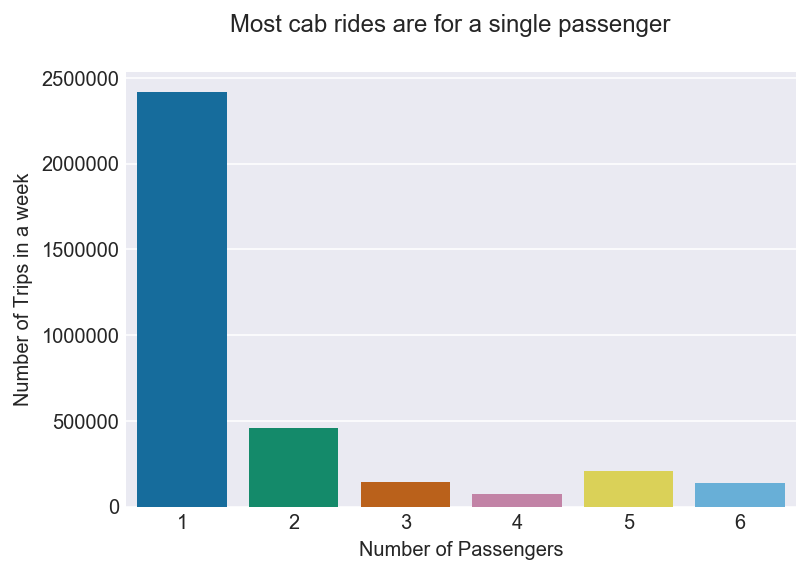

In [47]:
fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Most cab rides are for a single passenger')
ax = sns.countplot(x='passenger_count', data = taxi_df, palette = 'colorblind', ax=ax)
ax.set_xlabel('Number of Passengers')
ax.set_ylabel('Number of Trips in a week')
plt.ticklabel_format(style='plain', axis='y')
None

## 2. What is the distribution of payment type?

In [48]:
a = taxi_df.payment_type.value_counts()
a = a.to_frame().reset_index()
a = a.rename(columns={'index':'Type', 'payment_type':'Frequency'})
a_df = a
a_df

,Type,Frequency
0,CRD,1822762
1,CSH,1610113


In [49]:
# Could have used a dictionary here instead
a_df = a_df.replace('CRD','Credit Card')
a_df = a_df.replace('CSH','Cash')
#a_df = a_df.replace('NOC','No Charge')
#a_df = a_df.replace('DIS', 'Dispute')
#a_df = a_df.replace('UNK','Unknown')
a_df.set_index('Type', inplace=True)

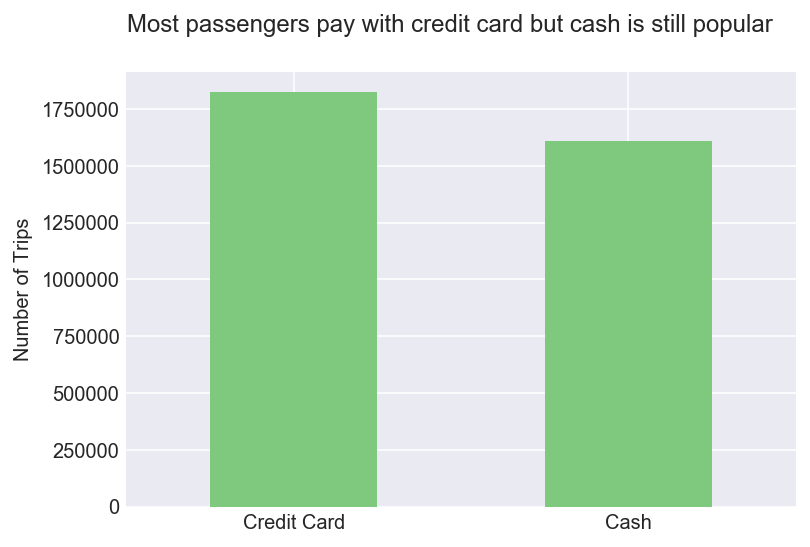

In [50]:
fig, ax = plt.subplots(figsize=(6,4))
ax = a_df.plot(kind='bar', cmap='Accent', legend=False, rot=0, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Number of Trips')
fig.suptitle('Most passengers pay with credit card but cash is still popular')
plt.ticklabel_format(style='plain', axis='y')
None

## 3. What is the distribution of the fare amount?

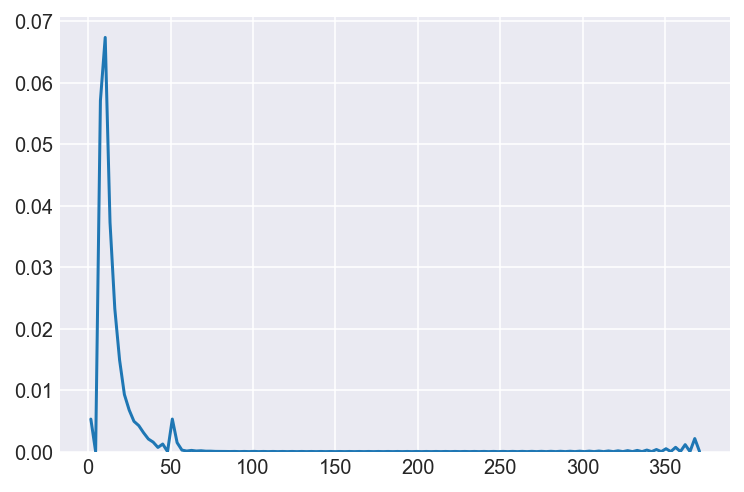

In [51]:
(fig, ax) = plt.subplots()
ax = sns.kdeplot(taxi_df.fare_amount, legend=False, ax=ax)
None

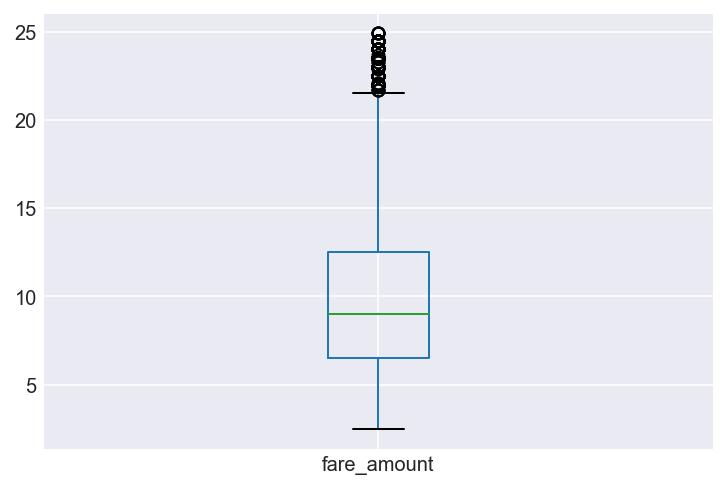

In [52]:
taxi_df[taxi_df.fare_amount<25].boxplot('fare_amount')
None

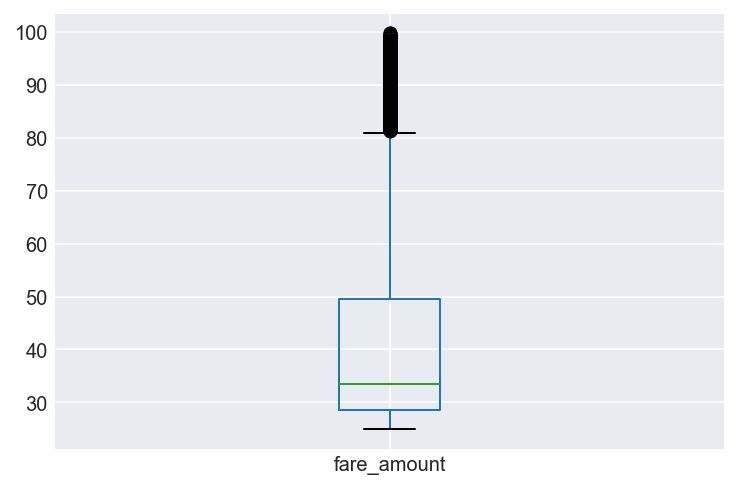

In [53]:
taxi_df[(taxi_df.fare_amount>=25)&(taxi_df.fare_amount<100)].boxplot('fare_amount')
None

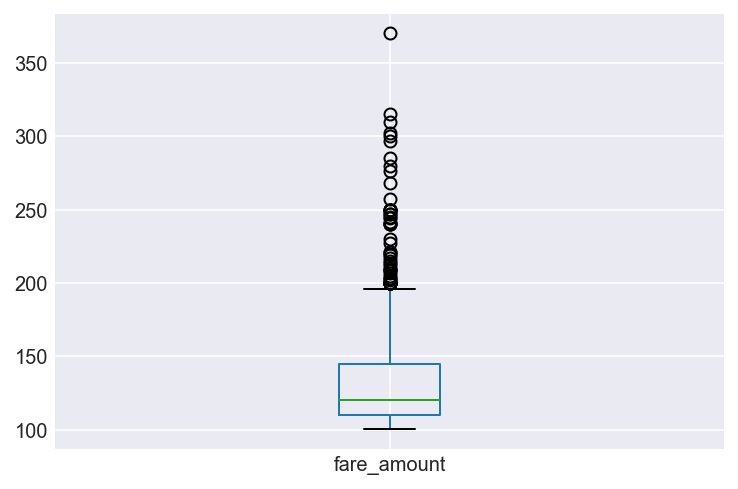

In [54]:
taxi_df[taxi_df.fare_amount>100].boxplot('fare_amount')
None

## 4. What is the distribution of the tip amount?

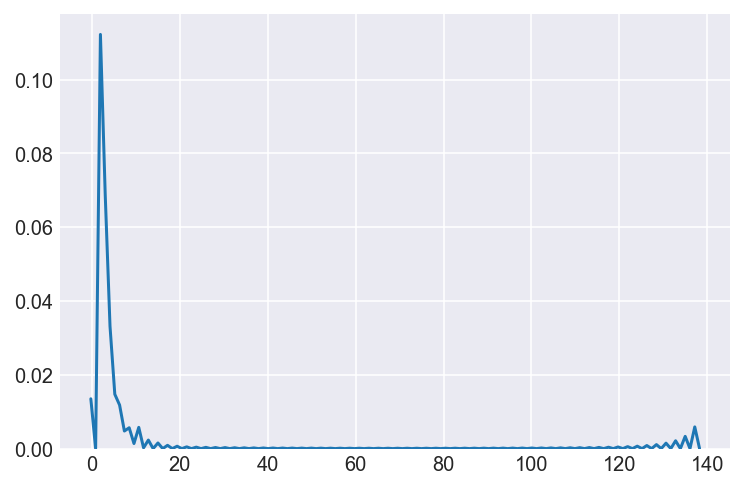

In [55]:
(fig, ax) = plt.subplots()
ax = sns.kdeplot(taxi_df.tip_amount, legend=False, ax=ax)
None

## 5. What is the distribution of the Total Amount?

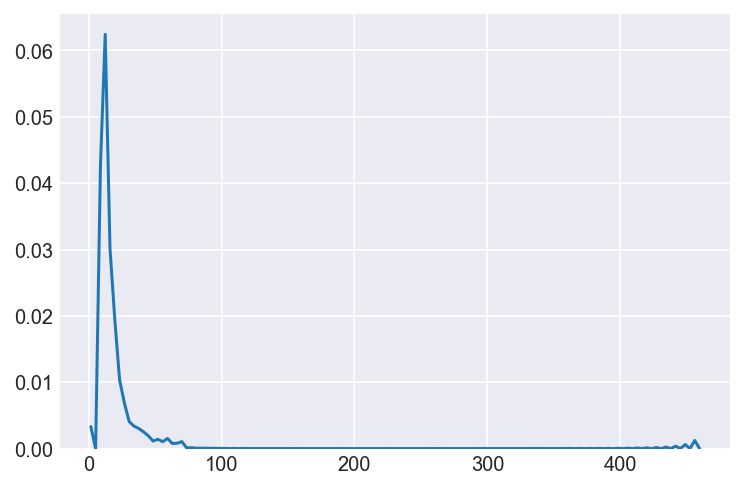

In [56]:
(fig, ax) = plt.subplots()
ax = sns.kdeplot(taxi_df.total_amount, legend=False, ax=ax)
None

## 6. What are the top 5 busiest hours of the day?

In [57]:
# Convert pickup_datetime and dropoff_datetime to datetime format
taxi_df['pickup_datetime'] = pd.to_datetime(taxi_df['pickup_datetime'])
taxi_df['dropoff_datetime'] = pd.to_datetime(taxi_df['dropoff_datetime'])
taxi_df.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.00,15.60
1,13048646BCF94CC2F5CB4EF34CE50527,975649E3088B0D2BD2DE377B49B0898D,VTS,1,2013-04-01,2013-04-01 00:31:00,4,1860,20.27,-73.776657,40.645325,-73.978203,40.673931,CRD,54.0,0.5,0.5,10.0,0.00,65.00
2,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028,CSH,34.0,0.5,0.5,0.0,0.00,35.00
3,6BB78818AFB34080166D1FB349EA2550,77A573BE341A4B887C566895F87B7D1C,VTS,5,2013-04-01,2013-04-01 00:32:00,4,1920,5.12,-73.987328,40.750397,-74.042847,40.720066,CSH,45.0,0.0,0.5,0.0,10.25,55.75
4,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716,CRD,5.0,0.5,0.5,1.1,0.00,7.10


In [58]:
# Use pickup datetime to determine hour e.g. if someone was picked up at 23:15:16, they were picked up at 2300 hours
taxi_df.groupby(taxi_df.pickup_datetime.dt.hour)['passenger_count'].sum().sort_values(ascending=False)

pickup_datetime
19    367150
20    362376
18    355777
21    354772
22    345277
23    303510
14    297275
12    292031
15    286956
17    285963
13    285859
11    278948
9     272587
10    266487
8     259570
16    237002
0     232151
7     207476
1     169089
2     127599
6     110077
3      94017
4      66716
5      51685
Name: passenger_count, dtype: int64

In [59]:
b = taxi_df.groupby(taxi_df.pickup_datetime.dt.hour)['passenger_count'].sum().sort_values(ascending=False).head()
b = b.to_frame().reset_index()
b = b.rename(columns={'pickup_datetime': 'hour'})
b_df = b.copy()
b_df

,hour,passenger_count
0,19,367150
1,20,362376
2,18,355777
3,21,354772
4,22,345277


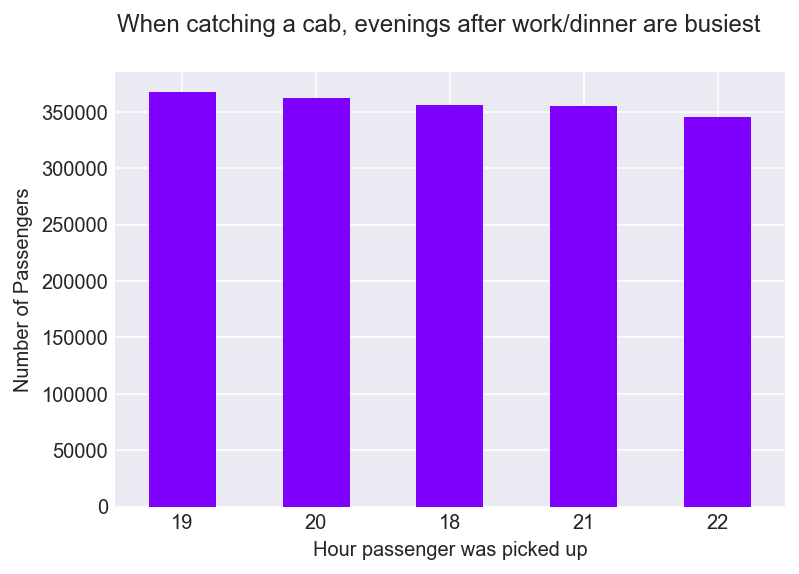

In [60]:
fig, ax = plt.subplots(figsize=(6,4))
ax = b_df.set_index('hour').plot(kind='bar', colormap='rainbow', legend=False, rot=0, ax=ax)
ax.set_xlabel('Hour passenger was picked up')
ax.set_ylabel('Number of Passengers')
fig.suptitle('When catching a cab, evenings after work/dinner are busiest')
plt.ticklabel_format(style='plain', axis='y')
None

## 7. What are the top 10 busiest locations in the city?

In [61]:
# 3 d.p. of precision will suffice
taxi_df2 = taxi_df.copy()
taxi_df2['pickup_latitude'] = taxi_df2.pickup_latitude.round(3)
taxi_df2['pickup_longitude'] = taxi_df2.pickup_longitude.round(3)
taxi_df2['dropoff_latitude'] = taxi_df2.dropoff_latitude.round(3)
taxi_df2['dropoff_longitude'] = taxi_df2.dropoff_longitude.round(3)
taxi_df2.tail()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
3443098,D5AF01D58DA48FFF46169C232017673F,BBB0371651B842361E8068F803BD5AFE,CMT,1,2013-04-07 23:59:56,2013-04-08 00:23:59,1,1443,6.3,-74.002,40.730,-73.954,40.788,CRD,22.0,0.5,0.5,4.6,0.0,27.6
3443099,7E64B77A336CD52A4A081F1B0066954C,6452FBD410A159B4A3E17C7EA4FE7293,CMT,1,2013-04-07 23:59:56,2013-04-08 00:05:38,1,342,1.4,-73.980,40.776,-73.963,40.764,CRD,7.0,0.5,0.5,1.6,0.0,9.6
3443100,6AC551DA4299581A398D8A9D0AC7C25F,541BC740DB8088C1AB92D770F664D8EC,CMT,1,2013-04-07 23:59:57,2013-04-08 00:02:25,1,147,1.0,-73.991,40.749,-74.001,40.737,CRD,5.0,0.5,0.5,1.5,0.0,7.5
3443101,23A3564F3D4A361A3D3F8D8FE8E7D2FF,90C3F339879C9E6C61805622382881D5,CMT,1,2013-04-07 23:59:58,2013-04-08 00:03:37,2,218,0.9,-73.990,40.751,-73.991,40.761,CSH,5.0,0.5,0.5,0.0,0.0,6.0
3443102,291758BBCA44E8AFF6554E526B423A39,5647761721D488C1F671072B01AA83F5,CMT,1,2013-04-07 23:59:59,2013-04-08 00:07:51,1,471,1.9,-73.989,40.734,-73.987,40.756,CSH,8.5,0.5,0.5,0.0,0.0,9.5


In [62]:
taxi_df2['pickup_geocode'] = taxi_df2.pickup_latitude.astype(str) + ', ' + taxi_df2.pickup_longitude.astype(str)
taxi_df2['dropoff_geocode'] = taxi_df2.dropoff_latitude.astype(str) + ', ' + taxi_df2.dropoff_longitude.astype(str)
taxi_df2.tail()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_geocode,dropoff_geocode
3443098,D5AF01D58DA48FFF46169C232017673F,BBB0371651B842361E8068F803BD5AFE,CMT,1,2013-04-07 23:59:56,2013-04-08 00:23:59,1,1443,6.3,-74.002,40.730,-73.954,40.788,CRD,22.0,0.5,0.5,4.6,0.0,27.6,"40.73, -74.002","40.788, -73.954"
3443099,7E64B77A336CD52A4A081F1B0066954C,6452FBD410A159B4A3E17C7EA4FE7293,CMT,1,2013-04-07 23:59:56,2013-04-08 00:05:38,1,342,1.4,-73.980,40.776,-73.963,40.764,CRD,7.0,0.5,0.5,1.6,0.0,9.6,"40.776, -73.98","40.764, -73.963"
3443100,6AC551DA4299581A398D8A9D0AC7C25F,541BC740DB8088C1AB92D770F664D8EC,CMT,1,2013-04-07 23:59:57,2013-04-08 00:02:25,1,147,1.0,-73.991,40.749,-74.001,40.737,CRD,5.0,0.5,0.5,1.5,0.0,7.5,"40.749, -73.991","40.737, -74.001"
3443101,23A3564F3D4A361A3D3F8D8FE8E7D2FF,90C3F339879C9E6C61805622382881D5,CMT,1,2013-04-07 23:59:58,2013-04-08 00:03:37,2,218,0.9,-73.990,40.751,-73.991,40.761,CSH,5.0,0.5,0.5,0.0,0.0,6.0,"40.751, -73.99","40.761, -73.991"
3443102,291758BBCA44E8AFF6554E526B423A39,5647761721D488C1F671072B01AA83F5,CMT,1,2013-04-07 23:59:59,2013-04-08 00:07:51,1,471,1.9,-73.989,40.734,-73.987,40.756,CSH,8.5,0.5,0.5,0.0,0.0,9.5,"40.734, -73.989","40.756, -73.987"


## 7a. What are the most popular pickup locations and zipcodes?

In [63]:
pickup = taxi_df2.groupby('pickup_geocode')['pickup_geocode'].count().sort_values(ascending=False).head(10)
pickup = pickup.to_frame().rename(columns={'pickup_geocode':'Number of Trips'}).reset_index()
pickup_df = pickup.copy()
pickup_df = pickup_df.rename(columns={'pickup_geocode':'Pickup_Geocode'})
pickup_df['location'] = pickup_df.Pickup_Geocode.apply(geolocator.reverse)
pickup_df['address'] = [i.address for i in pickup_df.location]
pickup_df['address'] = pickup_df['address'].astype(str)
pickup_df['zipcode'] = pickup_df['address'].str.extract('(\d{5})', expand=True).astype(int)
pickup_df.drop('location',axis=1,inplace=True)
pickup_df

,Pickup_Geocode,Number of Trips,address,zipcode
0,"40.751, -73.994",14708,"MSG, 46, West 31st Street, Manhattan Community Board 4, New York County, NYC, New York, NY 10001, United States of America",10001
1,"40.769, -73.863",13567,"East Elmhurst, Queens County, NYC, New York, 11368, United States of America",11368
2,"40.75, -73.992",13504,"Two Penn Plaza, 2, West 33rd Street, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001, United States of America",10001
3,"40.75, -73.991",12324,"Hotel Pennsylvania, 401, 7th Avenue, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001-2062, United States of America",10001
4,"40.774, -73.871",11752,"Discover NY, Central Terminal Drive, North Beach, Queens County, NYC, New York, 11368, United States of America",11368
5,"40.774, -73.873",10986,"HUdson Booksellers, Departures, North Beach, Queens County, NYC, New York, 11368, United States of America",11368
6,"40.757, -73.99",9777,"11 Times Square, 11, 8th Avenue, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10036, United States of America",10036
7,"40.756, -73.991",9122,"Chase, 615, 8th Avenue, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10018, United States of America",10018
8,"40.752, -73.978",8905,"One Grand Central Place, 120, Park Avenue, Manhattan Community Board 5, New York County, NYC, New York, 10016, United States of America",10016
9,"40.645, -73.782",8513,"Terminal 4 Pick-Up D, Terminal 4 Arrivals, Bayswater, Queens County, NYC, New York, 11434, United States of America",11434


## 7b. What are the most popular dropoff locations and zipcodes?

In [64]:
dropoff = taxi_df2.groupby('dropoff_geocode')['dropoff_geocode'].count().sort_values(ascending=False).head(10)
dropoff = dropoff.to_frame().rename(columns={'dropoff_geocode':'Number of Trips'}).reset_index()
dropoff_df = dropoff.copy()
dropoff_df = dropoff_df.rename(columns={'dropoff_geocode':'Dropoff_Geocode'})
dropoff_df['location'] = dropoff_df.Dropoff_Geocode.apply(geolocator.reverse)
dropoff_df['address'] = [i.address for i in dropoff_df.location]
dropoff_df['address'] = dropoff_df['address'].astype(str)
dropoff_df['zipcode'] = dropoff_df['address'].str.extract('(\d{5})', expand=True).astype(int)
dropoff_df.drop('location',axis=1,inplace=True)
dropoff_df

,Dropoff_Geocode,Number of Trips,address,zipcode
0,"40.75, -73.991",13543,"Hotel Pennsylvania, 401, 7th Avenue, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001-2062, United States of America",10001
1,"40.75, -73.995",10780,"410, 8th Avenue, Chelsea, Manhattan Community Board 4, New York County, NYC, New York, 10001, United States of America",10001
2,"40.751, -73.991",9981,"200, West 34th Street, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001, United States of America",10001
3,"40.749, -73.992",9890,"Emigrant Savings Bank, West 31st Street, Manhattan Community Board 4, New York County, NYC, New York, 10001, United States of America",10001
4,"40.762, -73.979",6150,"1321, 6th Avenue, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10019, United States of America",10019
5,"40.752, -73.978",6081,"One Grand Central Place, 120, Park Avenue, Manhattan Community Board 5, New York County, NYC, New York, 10016, United States of America",10016
6,"40.774, -73.871",5874,"Discover NY, Central Terminal Drive, North Beach, Queens County, NYC, New York, 11368, United States of America",11368
7,"40.75, -73.992",5778,"Two Penn Plaza, 2, West 33rd Street, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001, United States of America",10001
8,"40.757, -73.99",5644,"11 Times Square, 11, 8th Avenue, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10036, United States of America",10036
9,"40.752, -73.977",5471,"GCT, 89, East 42nd Street, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10017, United States of America",10017


## 8. Which trip has the highest standard deviation of travel times?
---

For each trip, map the pickup and dropoff addresses to zipcodes. Determine the standard deviation of travel times between zipcodes.

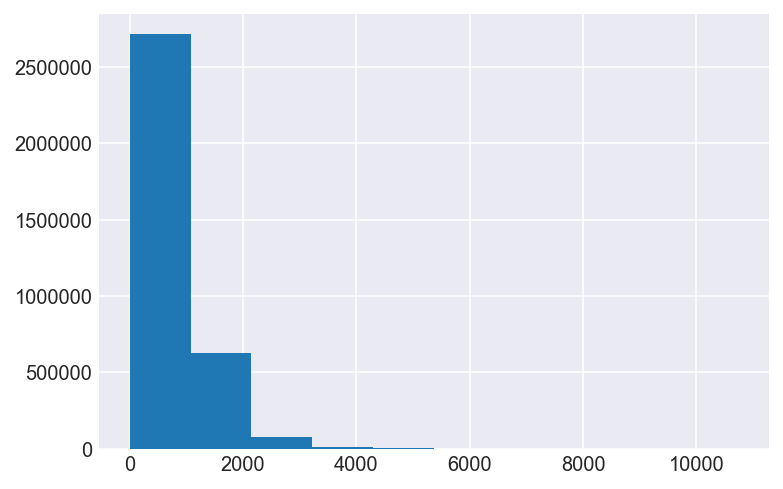

In [65]:
taxi_df2.trip_time_in_secs.hist()
None

In [66]:
taxi_df3 = taxi_df2.copy()
taxi_df3['route'] = taxi_df3.pickup_geocode + ' : ' + taxi_df3.dropoff_geocode
taxi_df3.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_geocode,dropoff_geocode,route
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01,2013-04-01 00:10:32,1,632,3.40,-73.994,40.747,-73.956,40.773,CRD,12.0,0.5,0.5,2.6,0.00,15.60,"40.747, -73.994","40.773, -73.956","40.747, -73.994 : 40.773, -73.956"
1,13048646BCF94CC2F5CB4EF34CE50527,975649E3088B0D2BD2DE377B49B0898D,VTS,1,2013-04-01,2013-04-01 00:31:00,4,1860,20.27,-73.777,40.645,-73.978,40.674,CRD,54.0,0.5,0.5,10.0,0.00,65.00,"40.645, -73.777","40.674, -73.978","40.645, -73.777 : 40.674, -73.978"
2,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01,2013-04-01 00:35:00,1,2100,10.29,-73.918,40.771,-73.900,40.754,CSH,34.0,0.5,0.5,0.0,0.00,35.00,"40.771, -73.918","40.754, -73.9","40.771, -73.918 : 40.754, -73.9"
3,6BB78818AFB34080166D1FB349EA2550,77A573BE341A4B887C566895F87B7D1C,VTS,5,2013-04-01,2013-04-01 00:32:00,4,1920,5.12,-73.987,40.750,-74.043,40.720,CSH,45.0,0.0,0.5,0.0,10.25,55.75,"40.75, -73.987","40.72, -74.043","40.75, -73.987 : 40.72, -74.043"
4,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01,2013-04-01 00:04:00,4,240,0.97,-73.959,40.720,-73.967,40.711,CRD,5.0,0.5,0.5,1.1,0.00,7.10,"40.72, -73.959","40.711, -73.967","40.72, -73.959 : 40.711, -73.967"


In [67]:
## Which trip has the highest standard deviation of travel times?
taxi_df3.groupby('route')['trip_time_in_secs'].std().sort_values(ascending=False).head(10)

route
40.759, -73.96 : 40.751, -73.976     6720.342848
40.758, -73.988 : 40.758, -73.989    6192.841190
40.735, -73.99 : 40.75, -73.992      5624.327338
40.647, -73.789 : 40.649, -73.783    5421.402033
40.647, -73.789 : 40.645, -73.791    5203.946675
40.645, -73.782 : 40.645, -73.788    5133.595231
40.76, -73.988 : 40.779, -73.988     5091.168825
40.646, -73.791 : 40.75, -73.972     5006.316011
40.65, -73.786 : 40.647, -73.79      4951.161682
40.644, -73.79 : 40.641, -73.787     4933.484012
Name: trip_time_in_secs, dtype: float64

In [68]:
# Let's look at a few of these routes...

In [69]:
start_loc = geolocator.reverse("40.759, -73.96")
print start_loc.address

Sutton East Tennis Club, Ed Koch Queensboro Bridge Outer Roadway, Upper East Side, Manhattan Community Board 8, New York County, NYC, New York, 10022, United States of America


In [70]:
end_loc = geolocator.reverse("40.751, -73.976")
print end_loc.address

Socony-Mobil Building, East 41st Street, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10017, United States of America


In [71]:
start_loc = geolocator.reverse("40.758, -73.988")
print start_loc.address

St. James Theatre, 246, West 44th Street, Hell's Kitchen, Manhattan Community Board 5, New York County, NYC, New York, 10036, United States of America


In [72]:
start_loc = geolocator.reverse("40.758, -73.989")
print start_loc.address

680, 8th Avenue, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10036, United States of America


## 9. Which trip has the most consistent fares?
---
Looking for those routes where standard deviation of fare amounts is among the lowest

In [73]:
taxi_df3.groupby('route')['fare_amount'].std().sort_values(ascending=True).head(10)

route
40.755, -73.888 : 40.753, -73.906    0.0
40.769, -73.985 : 40.716, -74.013    0.0
40.732, -73.991 : 40.741, -73.982    0.0
40.732, -73.991 : 40.739, -73.987    0.0
40.732, -73.991 : 40.735, -74.009    0.0
40.769, -73.985 : 40.735, -73.995    0.0
40.732, -73.991 : 40.731, -74.001    0.0
40.732, -73.991 : 40.729, -73.978    0.0
40.769, -73.985 : 40.706, -74.005    0.0
40.732, -73.991 : 40.728, -74.0      0.0
Name: fare_amount, dtype: float64

# Pickle Taxi Dataframe for use in modeling notebook

In [385]:
taxi_df.to_pickle('./DB/nyctaxidf.pickle')

# Misc Code - please ignore

In [155]:
# What are the 10 most popular taxicab pickup locations?
taxi_df3.groupby('pickup_geocode')['pickup_geocode'].count().sort_values(ascending=False).head(10)

pickup_geocode
40.751, -73.994    14765
40.769, -73.863    13644
40.75, -73.992     13587
40.75, -73.991     12395
40.774, -73.871    11811
40.774, -73.873    11049
40.757, -73.99      9816
40.756, -73.991     9163
40.752, -73.978     8950
40.645, -73.782     8742
Name: pickup_geocode, dtype: int64

In [239]:
e_df['zipcode'] = e_df['address'].str.extract('(\d{5})', expand=True).astype(int)
e_df

,Dropoff,Number of Trips,address,zipcode
0,"40.75, -73.991",13597,"Hotel Pennsylvania, 401, 7th Avenue, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001-2062, United States of America",10001
1,"40.75, -73.995",10836,"410, 8th Avenue, Chelsea, Manhattan Community Board 4, New York County, NYC, New York, 10001, United States of America",10001
2,"40.751, -73.991",10013,"200, West 34th Street, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001, United States of America",10001
3,"40.749, -73.992",9933,"Emigrant Savings Bank, West 31st Street, Manhattan Community Board 4, New York County, NYC, New York, 10001, United States of America",10001
4,"40.762, -73.979",6196,"1321, 6th Avenue, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10019, United States of America",10019
5,"40.752, -73.978",6115,"One Grand Central Place, 120, Park Avenue, Manhattan Community Board 5, New York County, NYC, New York, 10016, United States of America",10016
6,"40.774, -73.871",5911,"Discover NY, Central Terminal Drive, North Beach, Queens County, NYC, New York, 11368, United States of America",11368
7,"40.75, -73.992",5842,"Two Penn Plaza, 2, West 33rd Street, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001, United States of America",10001
8,"40.757, -73.99",5676,"11 Times Square, 11, 8th Avenue, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10036, United States of America",10036
9,"40.752, -73.977",5500,"GCT, 89, East 42nd Street, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10017, United States of America",10017


In [156]:
# Convert popular pickup locations into a dataframe
c = taxi_df3.groupby('pickup_geocode')['pickup_geocode'].count().sort_values(ascending=False).head(10)
c = c.to_frame().rename(columns={'pickup_geocode':'Number of Trips'}).reset_index()
c_df = c.copy()
c_df = c_df.rename(columns={'pickup_geocode':'Pickup'})
c_df

,Pickup,Number of Trips
0,"40.751, -73.994",14765
1,"40.769, -73.863",13644
2,"40.75, -73.992",13587
3,"40.75, -73.991",12395
4,"40.774, -73.871",11811
5,"40.774, -73.873",11049
6,"40.757, -73.99",9816
7,"40.756, -73.991",9163
8,"40.752, -73.978",8950
9,"40.645, -73.782",8742


In [234]:
e_df['address'] = e_df['address'].astype(str)
e_df

,Dropoff,Number of Trips,address
0,"40.75, -73.991",13597,"Hotel Pennsylvania, 401, 7th Avenue, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001-2062, United States of America"
1,"40.75, -73.995",10836,"410, 8th Avenue, Chelsea, Manhattan Community Board 4, New York County, NYC, New York, 10001, United States of America"
2,"40.751, -73.991",10013,"200, West 34th Street, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001, United States of America"
3,"40.749, -73.992",9933,"Emigrant Savings Bank, West 31st Street, Manhattan Community Board 4, New York County, NYC, New York, 10001, United States of America"
4,"40.762, -73.979",6196,"1321, 6th Avenue, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10019, United States of America"
5,"40.752, -73.978",6115,"One Grand Central Place, 120, Park Avenue, Manhattan Community Board 5, New York County, NYC, New York, 10016, United States of America"
6,"40.774, -73.871",5911,"Discover NY, Central Terminal Drive, North Beach, Queens County, NYC, New York, 11368, United States of America"
7,"40.75, -73.992",5842,"Two Penn Plaza, 2, West 33rd Street, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001, United States of America"
8,"40.757, -73.99",5676,"11 Times Square, 11, 8th Avenue, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10036, United States of America"
9,"40.752, -73.977",5500,"GCT, 89, East 42nd Street, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10017, United States of America"


In [233]:
e = taxi_df3.groupby('dropoff_geocode')['dropoff_geocode'].count().sort_values(ascending=False).head(10)
e = e.to_frame().rename(columns={'dropoff_geocode':'Number of Trips'}).reset_index()
e_df = e.copy()
e_df = e_df.rename(columns={'dropoff_geocode':'Dropoff'})
e_df['location'] = e_df.Dropoff.apply(geolocator.reverse)
e_df['address'] = [i.address for i in e_df.location]
e_df.drop('location',axis=1,inplace=True)
e_df

,Dropoff,Number of Trips,address
0,"40.75, -73.991",13597,"Hotel Pennsylvania, 401, 7th Avenue, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001-2062, United States of America"
1,"40.75, -73.995",10836,"410, 8th Avenue, Chelsea, Manhattan Community Board 4, New York County, NYC, New York, 10001, United States of America"
2,"40.751, -73.991",10013,"200, West 34th Street, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001, United States of America"
3,"40.749, -73.992",9933,"Emigrant Savings Bank, West 31st Street, Manhattan Community Board 4, New York County, NYC, New York, 10001, United States of America"
4,"40.762, -73.979",6196,"1321, 6th Avenue, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10019, United States of America"
5,"40.752, -73.978",6115,"One Grand Central Place, 120, Park Avenue, Manhattan Community Board 5, New York County, NYC, New York, 10016, United States of America"
6,"40.774, -73.871",5911,"Discover NY, Central Terminal Drive, North Beach, Queens County, NYC, New York, 11368, United States of America"
7,"40.75, -73.992",5842,"Two Penn Plaza, 2, West 33rd Street, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001, United States of America"
8,"40.757, -73.99",5676,"11 Times Square, 11, 8th Avenue, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10036, United States of America"
9,"40.752, -73.977",5500,"GCT, 89, East 42nd Street, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10017, United States of America"
